In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import anndata as ad

import pickle



In [2]:
path = "/nfs/team298/ls34/niche_colors.pkl"

with open(path, "rb") as f:
    colors_new2 = pickle.load(f)
colors=colors_new2

In [3]:
FILE_NAME = "adata_combined_new.h5ad.final.filtered"
PATH2=f'/nfs/team298/ls34/adult_skin/final_adatas/{FILE_NAME}'
adata_5k=sc.read_h5ad(PATH2)

def remove_markers(LIST):
    try: 
        LIST = {key: [gene for gene in genes if gene in adata_5k.var_names] 
                           for key, genes in LIST.items()}
    except: 
        LIST =[gene for gene in LIST if gene in adata_5k.var_names]
    return LIST



adata_5k.obs["lvl5_annotation_new"]=adata_5k.obs["lvl5_annotation"]
 

In [7]:
adata_5k=adata_5k[adata_5k.obs["niche19"].isin(["Plasma_cell_rich", "Sebaceous_immune"])]

adata_5k=adata_5k[~adata_5k.obs["Site_status"].str.startswith('Psoriasis_replicate')  ]
{x:x for x in adata_5k.obs["Site_status"].unique()}


{'Lesional': 'Lesional',
 'Non-lesional': 'Non-lesional',
 'Week 12': 'Week 12',
 'Day 14_HF': 'Day 14_HF',
 'Week 8 Psoriasis': 'Week 8 Psoriasis',
 '3D_Week12': '3D_Week12',
 '3D_Lesional_baseline': '3D_Lesional_baseline'}

In [11]:
adata_5k=adata_5k[adata_5k.obs["niche19"].isin(["Plasma_cell_rich", "Sebaceous_immune"])]
# exclude psoriasis replicates as same tissue section
adata_5k=adata_5k[adata_5k.obs["Site_status"].isin(['Lesional',
                                                    'Non-lesional',
                                                    'Week 12'
                                                   ])  ]
{x:x for x in adata_5k.obs["Site_status"].unique()}


{'Lesional': 'Lesional', 'Non-lesional': 'Non-lesional', 'Week 12': 'Week 12'}

/tmp/ipykernel_3043852/2942302073.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["niche19", "Site_status", "info_id6"])
/tmp/ipykernel_3043852/2942302073.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ct.groupby(["niche19", "Site_status"])["info_id6"]
/tmp/ipykernel_3043852/2942302073.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["niche19", "Site_status", "info_id6"])
/tmp/ipykern

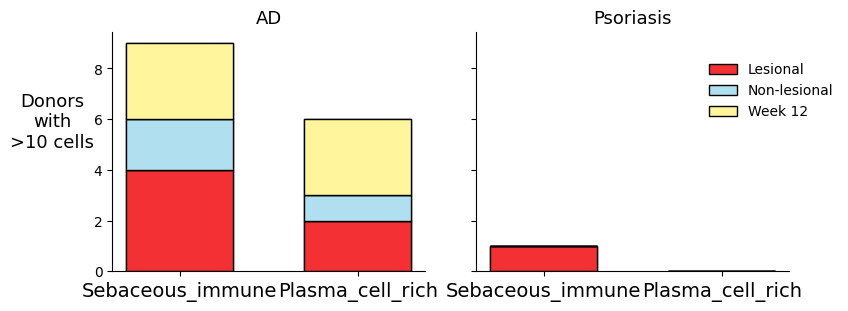

In [12]:
def donor_counts_stacked(df):
    ct = (
        df.groupby(["niche19", "Site_status", "info_id6"])
          .size()
          .reset_index(name="cells")
    )
    ct = ct[ct["cells"] > 10]
    
    pivot = (
        ct.groupby(["niche19", "Site_status"])["info_id6"]
          .nunique()
          .unstack(fill_value=0)
    )
    return pivot

# Compute stacked donor counts
diseases = adata_5k.obs["disease_overall"].unique()
donor_tables = {dis: donor_counts_stacked(adata_5k.obs.loc[adata_5k.obs["disease_overall"]==dis])
                for dis in diseases}

all_niches = pd.concat(donor_tables.values()).sum(axis=1).sort_values(ascending=False).index

# Plot
fig_w = 4 * len(diseases)
fig, axes = plt.subplots(1, len(diseases), figsize=(fig_w, 3), sharey=True, constrained_layout=True)
if len(diseases) == 1:
    axes = [axes]

site_colors = {'Lesional':"#F33033", 'Non-lesional':  "#b0e0f0", 'Week 12':"#FFF59D"}

for ax, dis in zip(axes, diseases):
    df = donor_tables[dis].reindex(all_niches).fillna(0)
    niches = df.index
    bottom = np.zeros(len(df))

    for site in df.columns:
        ax.bar(niches, df[site], bottom=bottom,
               color=site_colors.get(site, "grey"), 
               edgecolor="black", label=site,
               width=0.6)
        bottom += df[site].values

    ax.set_title(dis, fontsize=13)
    # Center xtick labels below bars
    ax.set_xticklabels(niches, rotation=0, ha="center", fontsize=14)
    ax.set_xlabel("")
    ax.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[0].set_ylabel(
    "Donors\nwith\n>10 cells",
    fontsize=13,
    rotation=0,
    labelpad=30
)

# Move legend up and right
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="upper right",
    bbox_to_anchor=(1.05, 0.85),  # right and up
    frameon=False,
    title=None,
    fontsize=10
)

plt.savefig("fig4/supp9b_hiddenniche_by_status_horizontal.pdf", dpi=300, bbox_inches="tight")
plt.show()